# Causal Interpretation for Employee Attrition Dataset

This notebook uses the popular kaggle Employee Attrition dataset to showcase how we could interpret a blackbox model from both the correlation and causation perspective, leveraging the power of model interpretation tools like [SHAP](https://shap.readthedocs.io/en/latest/index.html) and [EconML](https://aka.ms/econml). We start with a fine-tuned ML model and learn the top important features to predict employee attrition, it will help us to better understand the correlations between features and target and which features are the strongest predictors. In addition, this notebook will take a step further and focus more on figuring out which features cause the employees leave the company, instead of just predicting how likely they are going to leave. This extra causal interpretation could better help company to make corresponding changes in order to minimize the attrition rate.  

It includes the following sections:
1. [Train a Fine-tuned ML Model](#Train-a-Fine-tuned-ML-Model)
2. [Correlation Interpretation](#Correlation-Interpretation)
    * Feature Importance -- Learn the top predictors for a given ML model
3. [Causal Interpretation](#Causal-Interpretation)
    * Direct Causal Effect -- Do the top predictors also have a direct effect on outcome of interest?
    * Segmentation -- How to make individaulized plans to reduce the attrition?

In [1]:
# Some imports to get us started
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 100)

# Train a Fine-tuned ML Model
### Load the employee attrition data

In [2]:
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/EmployeeAttrition/Employee-Attrition.csv"
attritionData = pd.read_csv(file_url)
attritionData.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [3]:
# Dropping Employee count as all values are 1 and hence attrition is independent of this feature
attritionData = attritionData.drop(["EmployeeCount"], axis=1)
# Dropping Employee Number since it is merely an identifier
attritionData = attritionData.drop(["EmployeeNumber"], axis=1)
attritionData = attritionData.drop(["Over18"], axis=1)

# Since all values are 80
attritionData = attritionData.drop(["StandardHours"], axis=1)

# change the unit of income related variables
attritionData[["MonthlyIncome/1K", "MonthlyRate/1K"]] = (
    attritionData[["MonthlyIncome", "MonthlyRate"]] / 1000
)
attritionData = attritionData.drop(["MonthlyIncome", "MonthlyRate"], axis=1)

# Converting target variables from string to numerical values
target_map = {"Yes": 1, "No": 0}
attritionData["Attrition_numerical"] = attritionData["Attrition"].apply(
    lambda x: target_map[x]
)
target = attritionData["Attrition_numerical"]

attritionXData = attritionData.drop(["Attrition_numerical", "Attrition"], axis=1)

In [4]:
# Split data into train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    attritionXData, target, test_size=0.2, random_state=0, stratify=target
)

In [5]:
categorical = []
for col, value in attritionXData.iteritems():
    if value.dtype == "object":
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attritionXData.columns.difference(categorical)

### Make training pipeline

In [6]:
from sklearn.compose import ColumnTransformer

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="error", drop="first")),
    ]
)

transformations = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical),
        ("cat", categorical_transformer, categorical),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", transformations), ("classifier", LGBMClassifier())]
)

### Train a LightGBM classification model, which you want to explain

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": [0.1, 0.05, 0.01],
    "classifier__max_depth": [3, 5, 10],
}
search = GridSearchCV(clf, param_grid, n_jobs=-1)

In [8]:
search.fit(x_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3}

# Correlation Interpretation
We explain this ML model by understanding the top important features to predict the employee attrition, internally using shap value.

In [9]:
# get the fitted model and transformer
fitted_model = search.best_estimator_["classifier"]
fitted_transformer = search.best_estimator_["preprocessor"]
# get the feature name after featurization
column_names = numerical.tolist()
column_names += (
    search.best_estimator_["preprocessor"]
    .transformers_[1][1]
    .steps[1][1]
    .get_feature_names(categorical)
    .tolist()
)

In [10]:
import shap

# use interventional approach
background = shap.maskers.Independent(
    fitted_transformer.transform(x_train), max_samples=2000
)
explainer = shap.TreeExplainer(
    fitted_model, data=background, feature_names=column_names
)
shap_values = explainer(fitted_transformer.transform(x_test))

Passing 1176 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


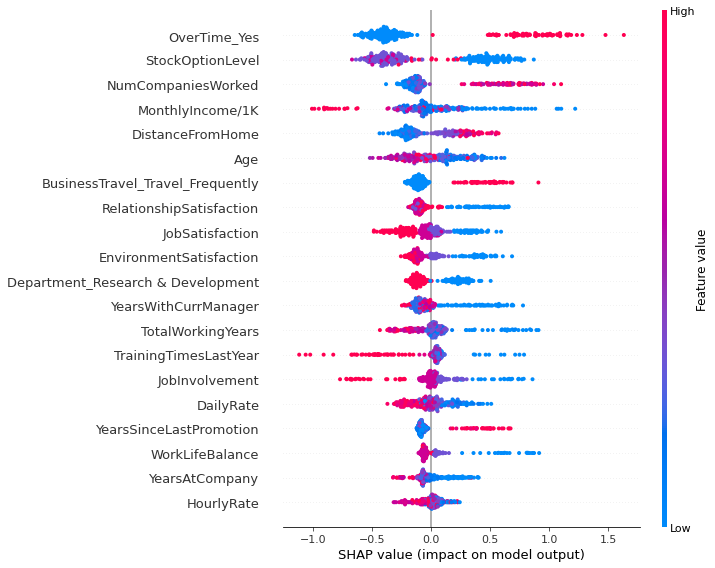

In [11]:
# plot the feature importance
shap.summary_plot(shap_values, fitted_transformer.transform(x_test))

From the summary plot above, we could see the most important features sorted by their importance level. Taking the top 5 important features as an example, employees who often work overtime, have frequently changed jobs or live far away from their worksite are more likely to leave the company, and employees with higher income and stock options are less likely to leave. However, it doesn't mean these are the drivers that directly cause the employee to leave, it might have hidden variables that affect both the top features and outcome. For example, maybe the inefficient collaboration environment forces the employee to work overtime and also causes them to leave, instead of working overtime itself. In order to correctly find the direct reason and make improvements accordingly, we have to train a different model controlling on all the possible hidden variables (confounders) and learn the direct causal effect for a given feature. That's what the causal interpretation tool is doing. In the following session, we will explain the causal relationship for the top 5 important features.

# Causal Interpretation
### Direct Causal Effect --  Do the top predictors also have a direct effect on outcome of interest?

In [12]:
classification = True
k = 5
# get top feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns=["features", "importance"]
)
feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)
top_features = feature_importance.iloc[:k]["features"]
# extract the raw feature name for top features
top_features = [i.split("_")[0] for i in top_features]

In [13]:
from econml.solutions.causal_analysis import CausalAnalysis

ca = CausalAnalysis(
    top_features,
    categorical,
    heterogeneity_inds=None,
    classification=True,
    nuisance_models="automl",
    heterogeneity_model="forest",
    n_jobs=-1,
)
ca.fit(x_train, y_train.values)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


In [14]:
global_summ = ca.global_causal_effect(alpha=0.05)
global_summ

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
OverTime,YesvNo,0.211192,0.023247,9.084544,1.041338e-19,0.165628,0.256756
StockOptionLevel,num,-0.017507,0.029796,-0.587555,5.568309e-01,-0.075907,0.040893
NumCompaniesWorked,num,0.024221,0.007400,3.272942,1.064345e-03,0.009716,0.038725
MonthlyIncome/1K,num,-0.011077,0.012029,-0.920860,3.571233e-01,-0.034653,0.012499
DistanceFromHome,num,0.003981,0.002086,1.908791,5.628909e-02,-0.000107,0.008069


In [15]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")
    plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


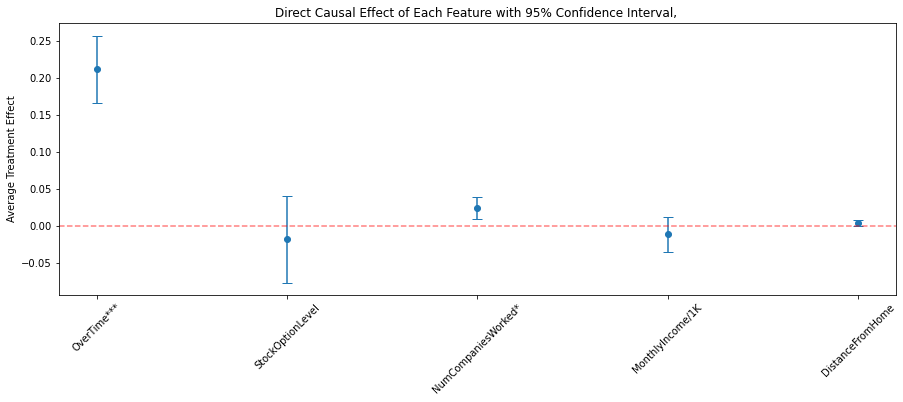

In [16]:
errorbar(global_summ)

We learn the Average Treatment Effect(ATE) for each of the top 5 important features, assuming they are the treatment. From the summary table and the error bar plot above, we see the causal effect directions we learnt here are in line with the correlation directions we learnt above. However, features like `StockOptionLevel` or `MonthlyIncome/1K` although they are the strongest predictors on how likely employees will leave, we are less confident to say these are the drivers causing them leave. This is super valuable for the managers when they are trying to make plans to reduce the employee attrition rate, improving work life balance or providing extra support for employees who are living far away from the company might be more effective than raise their salary/stocks.          

### Segmentation -- How to make individaulized plans to reduce the attrition?
From the analysis above, we learnt the direct treatment effect of each top features from an overall average level. However, people in different life stage or working experience might have different response to each of this potential reasons. Since the salary related features are not sigificant in an average level, we are interested to find the sub-groups who will respond positively to the income raise. If we could find a sub-group who have sigificant effect on income, we could further help the managers to refine their strategy and make individualized plans to different employees. 

In [17]:
local_summ = ca.local_causal_effect(x_test)

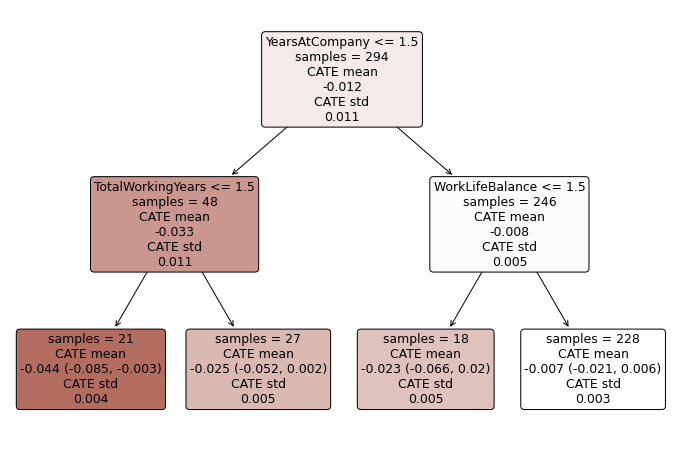

In [18]:
plt.figure(figsize=(12, 8))
ca.plot_heterogeneity_tree(
    x_test, "MonthlyIncome/1K", max_depth=2, min_impurity_decrease=1e-8
)

This shallow tree interpreter gives us a clear guidance on what we should target on. Employees with years of total working experience less than 1.5 have siginificant negative effect on monthly income, that means increase income will definitely reduce the rate of attrition for them. On the other side, employees who have already worked for this company in a long time and are relatively happy with the work life balance here might be less responsive to the income raise, salary might not be an important driver if they decide to leave.